# Graph Neural Networks

## Import Required Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.data import Data

import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc


## GCN Model Definition

In [2]:
# ------------------------------------------------------
# -----Graph Convoultional Network Model Definition-----
# ------------------------------------------------------

class GCN_Classification(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate):
        super(GCN_Classification, self).__init__()
        
        # Initialize a list to hold GCN layers
        self.convs = torch.nn.ModuleList()

        # Initialize droput layer
        self.dropout_rate = dropout_rate

        # First layer: input_dim → first hidden dim
        self.convs.append(GCNConv(input_dim, hidden_dims[0]))

        # Hidden layers: hidden_dims[i-1] → hidden_dims[i]
        for i in range(1, len(hidden_dims)):
            self.convs.append(GCNConv(hidden_dims[i - 1], hidden_dims[i]))

        # Final layer: last hidden dim → output
        self.out = GCNConv(hidden_dims[-1], output_dim)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight

        for conv in self.convs:
            x = conv(x, edge_index, edge_weight)
            x = F.relu(x)
            x = F.dropout(x, p = self.dropout_rate, training = self.training)

        x = self.out(x, edge_index, edge_weight)
        return F.log_softmax(x, dim = 1)
    

# --------------------------------------------------
# -----Graph Attention Network Model Definition-----
# --------------------------------------------------

class GAT_Classification(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate, heads = 2):
        super(GAT_Classification, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.dropout_rate = dropout_rate
        self.heads = heads

        # First GAT layer
        self.convs.append(GATConv(input_dim, hidden_dims[0], heads = heads, concat = True))

        # Intermediate GAT layers
        for i in range(1, len(hidden_dims)):
            self.convs.append(GATConv(hidden_dims[i - 1] * heads, hidden_dims[i], heads = heads, concat = True))

        # Final GAT layer (heads = 1 to avoid over-expanding feature size)
        self.out = GATConv(hidden_dims[-1] * heads, output_dim, heads = 1, concat = False)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.elu(x)
            x = F.dropout(x, p = self.dropout_rate, training = self.training)

        x = self.out(x, edge_index)
        return F.log_softmax(x, dim = 1)



## Model Training Function

In [3]:
def train_model(data, input_dim, output_dim, hidden_dim, lr, weight_decay, optimizer_type, dropout_rate, epochs, model_type):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if model_type == "GCN":
        model = GCN_Classification(input_dim, hidden_dim, output_dim, dropout_rate).to(device)
    elif model_type == "GAT":
        model = GAT_Classification(input_dim, hidden_dim, output_dim, dropout_rate).to(device)
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    data = data.to(device)

    if optimizer_type == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)
    elif optimizer_type == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr = lr, weight_decay = weight_decay)
    elif optimizer_type == "RMSprop":
        optimizer = torch.optim.RMSprop(model.parameters(), lr = lr, weight_decay = weight_decay)
    else:
        raise ValueError("Unsupported optimizer")

    train_losses = []
    val_losses = []
    val_accuracies = []

    best_val_loss = float("inf")
    best_model_state = None
    epochs_no_improve = 0
    patience = 20

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_out = out[data.val_mask]
            val_y = data.y[data.val_mask]
            val_loss = F.nll_loss(val_out, val_y)
            val_losses.append(val_loss.item())

            val_pred = out.argmax(dim = 1)[data.val_mask]
            val_acc = (val_pred == val_y).sum().item() / int(data.val_mask.sum())
            val_accuracies.append(val_acc)

            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                epochs_no_improve = 0
                best_model_state = model.state_dict()
            else:
                epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

    model.load_state_dict(best_model_state)

    best_val_loss = val_losses[-1]
    
    return model, best_val_loss, train_losses, val_accuracies, val_losses

## Hyperparameter Tuning Function

In [4]:
def hyperparameter_tuning(data, input_dim, output_dim, param_grid, epochs, model_type):
    best_model = None
    best_loss = float("inf")
    best_config = None

    model_counter = 1
    total_model_count = (len(param_grid['hidden_dim']) *
                    len(param_grid['lr']) *
                    len(param_grid['weight_decay']) *
                    len(param_grid['optimizer']) *
                    len(param_grid['dropout_rate']))

    for hidden_dim in param_grid['hidden_dim']:
        for lr in param_grid['lr']:
            for weight_decay in param_grid['weight_decay']:
                for opt_name in param_grid['optimizer']:
                    for dropout_rate in param_grid['dropout_rate']:
                        print(f"Model {model_counter}/{total_model_count}: hidden_dim = {hidden_dim} | lr = {lr} | weight_decay = {weight_decay} | optimizer = {opt_name} | dropout_rate = {dropout_rate}")
                        try:
                            model, val_loss, train_losses, val_accuracies, val_losses  = train_model(data, input_dim, output_dim, hidden_dim, lr, weight_decay, opt_name, dropout_rate, epochs, model_type)
                            print(f"Best Validation Loss: {val_loss:.4f}\n")
                            
                            if val_loss < best_loss:
                                best_loss = val_loss
                                best_model = model
                                best_config = {
                                    "hidden_dim": hidden_dim,
                                    "lr": lr,
                                    "weight_decay": weight_decay,
                                    "optimizer": opt_name,
                                    "dropout_rate": dropout_rate
                                }
                        except Exception as e:
                            print(f"Failed with {opt_name}: {e}")

                        model_counter += 1

    return best_model, best_config, best_loss


## Movie Rating Classification - GCN and GAT

### Load Dataset and Preprocess

In [161]:
# Load GraphML with NetworkX
G = nx.read_graphml("../data/networks/movie_similarity_network_all_ratings.graphml")

# Extract node features and labels
node_ids = list(G.nodes)
num_nodes = len(node_ids)

# Pick node attributes as features
feature_names = ["budget", "revenue", "oscar_noms", "oscar_wins", "runtime", "year"]
features = []
ratings = []

for n in node_ids:
    node_data = G.nodes[n]
    # Extract features and convert to float, handle missing data if needed
    f = []
    for attr in feature_names:
        val = node_data.get(attr)
        try:
            f.append(float(val) if val is not None else 0.0)
        except ValueError:
            f.append(0.0)
    features.append(f)

    # Rating
    rating_val = node_data.get("avg_rating")
    try:
        rating = float(rating_val)
    except (TypeError, ValueError):
        rating = np.nan
    ratings.append(rating)

numeric_features = np.array(features)
ratings = np.array(ratings)

### Encode Text Features

In [162]:
# Extract strings
genre_list = []
age_rating_list = []

for n in node_ids:
    node_data = G.nodes[n]
    
    # Extract Genres
    raw = G.nodes[n].get("genre", "[]")
    try:
        genres = eval(raw)  # convert string to list
    except:
        genres = []
    genre_list.append(genres)

    # Extract Age Rating and split on semicolon
    raw_age_rating = node_data.get("age_rating", "")
    if isinstance(raw_age_rating, str) and raw_age_rating.strip():
        age_rating = raw_age_rating.strip()
    else:
        age_rating = ""
    age_rating_list.append(age_rating)

# Convert to multi-hot encoding
mlb_genre = MultiLabelBinarizer()
mlb_age_rating = MultiLabelBinarizer()

genre_features = mlb_genre.fit_transform(genre_list)
age_rating_features = mlb_age_rating.fit_transform(age_rating_list)

# Calculate centralities
deg_centrality = nx.degree_centrality(G)
close_centrality = nx.closeness_centrality(G)
betw_centrality = nx.betweenness_centrality(G)
eigen_centrality = nx.eigenvector_centrality(G, max_iter = 1000)

# Map to feature list
centrality_features = []
for nid in node_ids:
    centrality_features.append([
        deg_centrality.get(nid, 0.0),
        close_centrality.get(nid, 0.0),
        betw_centrality.get(nid, 0.0),
        eigen_centrality.get(nid, 0.0)
    ])
centrality_features = np.array(centrality_features)

combined_features = np.hstack([numeric_features, genre_features, age_rating_features])

print("Genre shape:", genre_features.shape)
print("Age Rating shape:", age_rating_features.shape)
print("Centrality Shape:", centrality_features.shape)
print("Combined features shape:", combined_features.shape)

combined_features = np.hstack([numeric_features, genre_features])

Genre shape: (6940, 19)
Age Rating shape: (6940, 9)
Centrality Shape: (6940, 4)
Combined features shape: (6940, 34)


### Bucketize Target Variables

In [163]:
# Quantile-based rating buckets
valid_ratings_mask = ~np.isnan(ratings)
valid_ratings = ratings[valid_ratings_mask]
classes = 3
quantiles = [np.quantile(valid_ratings, i / classes) for i in range(1, classes)]

def bucketize_rating_quantile(r, quantiles):
    if np.isnan(r):
        return -1
    for i, q in enumerate(quantiles):
        if r <= q:
            return i
    return len(quantiles)

labels = np.array([bucketize_rating_quantile(r, quantiles) for r in ratings])

# Print readable label ranges
unique, counts = np.unique(labels, return_counts = True)

for label, count in zip(unique, counts):
    if label == 0:
        print(f"Label {label}: {count} movies - (rating <= {quantiles[0]:.2f})")
    elif label == classes - 1:
        print(f"Label {label}: {count} movies - (rating > {quantiles[-1]:.2f})")
    else:
        lower = quantiles[label - 1]
        upper = quantiles[label]
        print(f"Label {label}: {count} movies - ({lower:.2f} < rating <= {upper:.2f})")

Label 0: 2315 movies - (rating <= 5.73)
Label 1: 2315 movies - (5.73 < rating <= 7.08)
Label 2: 2310 movies - (rating > 7.08)


### Remove NaN Nodes and Edges

In [164]:
# Filter valid rows: no NaNs in features + valid labels
features = combined_features
valid_features_mask = ~np.isnan(features).any(axis = 1)
valid_labels_mask = labels != -1
valid_rows = valid_features_mask & valid_labels_mask

features_filtered = features[valid_rows]
labels_filtered = labels[valid_rows]
node_ids_filtered = np.array(node_ids)[valid_rows]
node_id_to_idx = {nid: idx for idx, nid in enumerate(node_ids_filtered)}

# Map old node indices to new
old_to_new = -np.ones(len(node_ids), dtype = int)
old_to_new[np.where(valid_rows)[0]] = np.arange(features_filtered.shape[0])

# Build edge_index and edge_weight using filtered nodes only
filtered_edges_with_weights = []

for src, dst, attr in G.edges(data = True):
    if src in node_id_to_idx and dst in node_id_to_idx:
        new_src = node_id_to_idx[src]
        new_dst = node_id_to_idx[dst]

        weight = float(attr.get("weight", 1.0))
        filtered_edges_with_weights.append((new_src, new_dst, weight))

# Build edge_index and edge_weight tensors
edge_index = torch.tensor([[e[0], e[1]] for e in filtered_edges_with_weights], dtype = torch.long).t().contiguous()
edge_weight = torch.tensor([e[2] for e in filtered_edges_with_weights], dtype = torch.float)

num_nodes_filtered = features_filtered.shape[0]
print("Number of nodes before filtering:", len(node_ids))
print("Number of nodes before filtering:", num_nodes_filtered, "\n")

unique, counts = np.unique(labels_filtered, return_counts = True)

for label, count in zip(unique, counts):
    print(f"Label {label}: {count} nodes")

Number of nodes before filtering: 6940
Number of nodes before filtering: 6746 

Label 0: 2196 nodes
Label 1: 2302 nodes
Label 2: 2248 nodes


### Standardize Features and Convert to Torch Tensors

In [165]:
scaler = StandardScaler()
features_filtered = scaler.fit_transform(features_filtered)

# Convert to torch tensors
x = torch.tensor(features_filtered, dtype = torch.float)
y = torch.tensor(labels_filtered, dtype = torch.long)

### Split the Dataset into Training, Validation, and Testing Sets

In [166]:
# Create train/test masks
num_nodes = num_nodes_filtered
num_train = int(0.8 * num_nodes)
num_val = int(0.1 * num_nodes)
num_test = num_nodes - num_train - num_val

perm = torch.randperm(num_nodes)
train_idx = perm[:num_train]
val_idx = perm[num_train : num_train + num_val]
test_idx = perm[num_train + num_val:]

train_mask = torch.zeros(num_nodes, dtype = torch.bool)
val_mask = torch.zeros(num_nodes, dtype = torch.bool)
test_mask = torch.zeros(num_nodes, dtype = torch.bool)

train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

# Create data object
data = Data(x = x,
            edge_index = edge_index,
            edge_weight = edge_weight,
            y = y,
            train_mask = train_mask,
            val_mask = val_mask,
            test_mask = test_mask)

In [148]:
nan_mask = np.isnan(features_filtered)
print("NaNs per column:", np.sum(nan_mask, axis = 0))

NaNs per column: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Tune Hyperparameters (GCN)

In [ ]:
param_grid = {
    "hidden_dim": [[128]],
    "lr": [0.01],
    "weight_decay": [1e-3],
    "optimizer": ["Adam"],
    "dropout_rate": [0.2]
}

best_model, best_config, best_loss = hyperparameter_tuning(
    data = data,
    input_dim = x.shape[1],
    output_dim = len(np.unique(labels)),
    param_grid = param_grid,
    epochs = 200,
    model_type = "GCN"
)

# Print best model configuration
print(f"Best Config: {best_config}")
print(f"Best Validation Loss: {best_loss:.4f}")

'''
-----PREVIOUS BEST-----
Best Config: {'hidden_dim': [128], 'lr': 0.01, 'weight_decay': 0.001, 'optimizer': 'Adam', 'dropout_rate': 0.2}
Best Validation Loss: 0.9928
Test Accuracy: 0.4675
'''

Model 1/1: hidden_dim = [128] | lr = 0.01 | weight_decay = 0.001 | optimizer = Adam | dropout_rate = 0.2
Early stopping triggered at epoch 91
Best Validation Loss: 0.9873

Best Config: {'hidden_dim': [128], 'lr': 0.01, 'weight_decay': 0.001, 'optimizer': 'Adam', 'dropout_rate': 0.2}
Best Validation Loss: 0.9873


"\n-----PREVIOUS BEST-----\nBest Config: {'hidden_dim': [128], 'lr': 0.01, 'weight_decay': 0.001, 'optimizer': 'Adam', 'dropout_rate': 0.2}\nBest Validation Loss: 1.0466\nTest Accuracy: 0.4663\n"

### Train the Best Model (GCN)

In [176]:
# Retrain with best hyperparameters
best_model, best_val_loss, train_losses, val_accuracies, val_losses = train_model(
    data = data,
    input_dim = data.num_node_features,
    output_dim = len(np.unique(labels_filtered)),
    hidden_dim = best_config["hidden_dim"],
    lr = best_config["lr"],
    weight_decay = best_config["weight_decay"],
    optimizer_type = best_config["optimizer"],
    dropout_rate = best_config["dropout_rate"],
    epochs = 200,
    model_type = "GCN"
)

print(f"Best Model: {best_model}")
print(f"Best Validation Loss: {best_val_loss:.4f}")

Early stopping triggered at epoch 129
Best Model: GCN_Classification(
  (convs): ModuleList(
    (0): GCNConv(25, 128)
  )
  (out): GCNConv(128, 3)
)
Best Validation Loss: 0.9928


### Visualize Training and Validation Results (GCN)

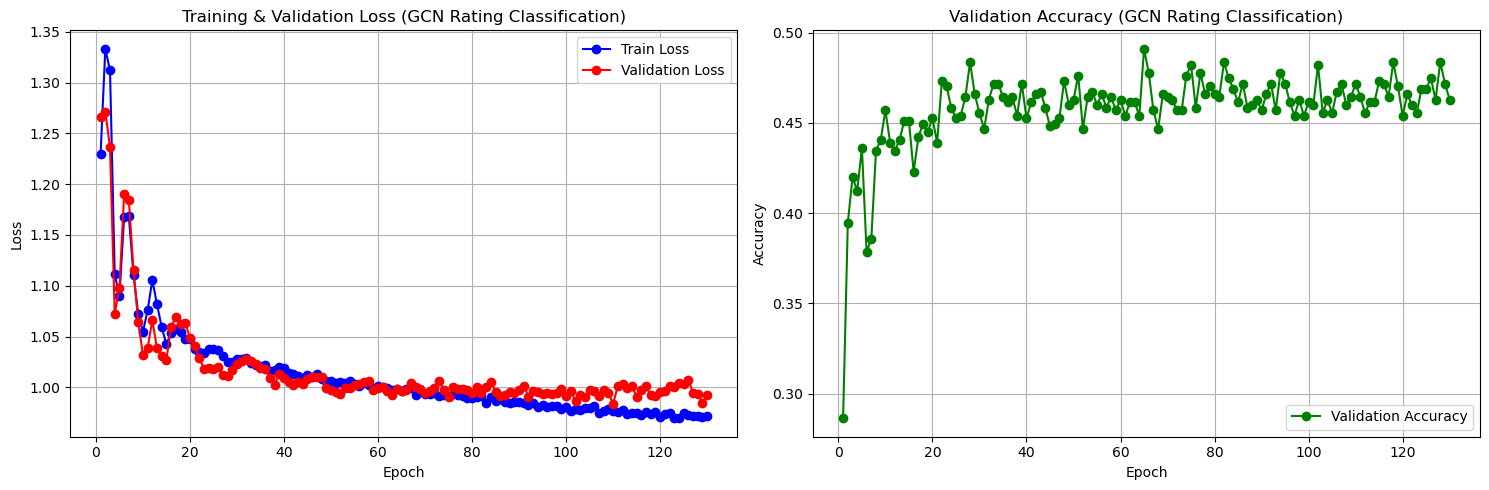

In [ ]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize = (15, 5))

# Subplot 1: Losses
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label = "Train Loss", color = "blue", marker = "o")
plt.plot(epochs, val_losses, label = "Validation Loss", color = "red", marker = "o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss (GCN Rating Classification)")
plt.grid(True)
plt.legend()

# Subplot 2: Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label = "Validation Accuracy", color = "green", marker = "o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy (GCN Rating Classification)")
plt.grid(True)
plt.legend()

plt.tight_layout()
#plt.savefig("../assets/GCN_rating_classification_loss_curves.png", dpi = 300, bbox_inches = "tight")  # Save to file

plt.show()

### Evaluate the Model on the Test Set (GCN)

In [178]:
# Evaluate best model on test set
best_model.eval()
with torch.no_grad():
    out = best_model(data)  # [num_nodes, num_classes]
    pred = out.argmax(dim = 1)

    y_true = data.y[data.test_mask].cpu().numpy()
    y_pred = pred[data.test_mask].cpu().numpy()

    acc = (y_pred == y_true).mean()
    print(f"Best Config: {best_config}")
    print(f"Test Accuracy: {acc:.4f}")

Best Config: {'hidden_dim': [128], 'lr': 0.01, 'weight_decay': 0.001, 'optimizer': 'Adam', 'dropout_rate': 0.2}
Test Accuracy: 0.4675


### Confusion Matrix (GCN)

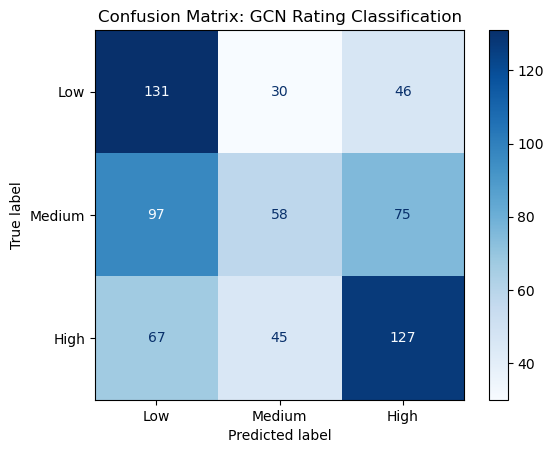

In [ ]:
# Plot all ROC curves
display_labels = [
    "Low",
    "Medium",
    "High"
]

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = display_labels)
disp.plot(cmap = plt.cm.Blues)
plt.title("Confusion Matrix: GCN Rating Classification")
#plt.savefig("../assets/GCN_rating_classification_confusion_matrix.png", dpi = 300, bbox_inches = "tight")  # Save to file

plt.show()


### ROC Curve (GCN)

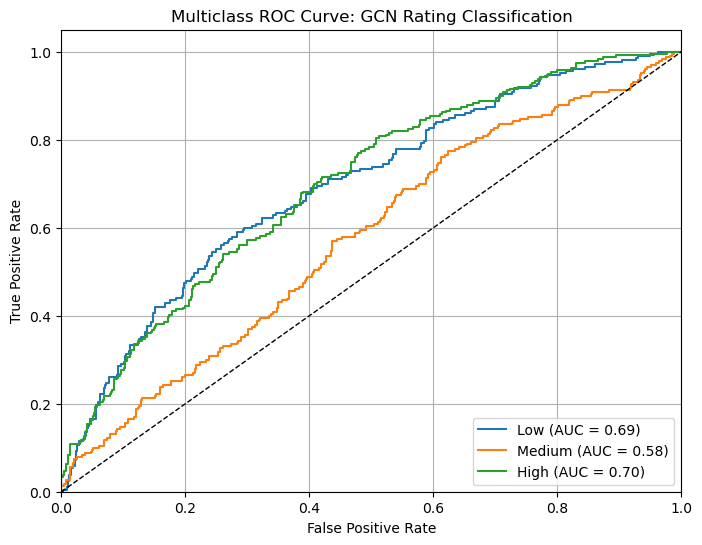

In [ ]:
# Get predicted probabilities
probs = out[data.test_mask].cpu().numpy()

display_labels = np.unique(labels_filtered)

# Binarize true labels for multiclass ROC
y_test_bin = label_binarize(y_true, classes = display_labels)
n_classes = probs.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
display_labels = [
    "Low",
    "Medium",
    "High"
]

plt.figure(figsize = (8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label = f"{display_labels[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw = 1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve: GCN Rating Classification")
plt.legend(loc = "lower right")
plt.grid(True)
#plt.savefig("../assets/GCN_rating_classification_roc_curve.png", dpi = 300, bbox_inches = "tight")
plt.show()

### Track Test Results

In [184]:
test_mask = data.test_mask.cpu().numpy()
test_indices = np.where(test_mask)[0]  # indices of test nodes

# Ensure arrays
node_ids_array = np.array(node_ids)
ratings_array = np.array(ratings)

# Get movie names, true labels for test nodes
# Subset for test nodes
movie_ids_test = node_ids_array[valid_rows][test_indices]
true_labels_test = labels_filtered[test_indices]
true_ratings_test = ratings_array[valid_rows][test_indices]

df_test_results = pd.DataFrame({
    "movie_id": movie_ids_test,
    "rating": true_ratings_test,
    "true_label": true_labels_test,
    "pred_label": y_pred
})

df_test_results["correct"] = df_test_results["true_label"] == df_test_results["pred_label"]

accuracy = (df_test_results["true_label"] == df_test_results["pred_label"]).mean()
print(f"Test Accuracy: {accuracy:.3f}")

df_test_results.head(20)


Test Accuracy: 0.467


,movie_id,rating,true_label,pred_label,correct
0,Avengers: Endgame,8.450,2,2,True
1,Furious 7,7.300,2,2,True
2,Rogue One: A Star Wars Story,7.550,2,2,True
3,Pirates of the Caribbean: At World's End,5.925,1,0,False
4,Star Wars: Episode I - The Phantom Menace,5.900,1,2,False
5,Batman v Superman: Dawn of Justice,4.925,0,2,False
6,Wonder Woman,7.850,2,1,False
7,Captain America: The Winter Soldier,7.850,2,2,True
8,Transformers,6.425,1,0,False
9,Fast Five,7.225,2,0,False


### Tune Hyperparameters (GAT)

In [185]:
param_grid = {
    "hidden_dim": [[64], [128]],
    "lr": [0.01],
    "weight_decay": [1e-3],
    "optimizer": ["Adam"],
    "dropout_rate": [0.2]
}

best_model, best_config, best_loss = hyperparameter_tuning(
    data = data,
    input_dim = x.shape[1],
    output_dim = len(np.unique(labels)),
    param_grid = param_grid,
    epochs = 200,
    model_type = "GAT"
)

# Print best model configuration
print(f"Best Config: {best_config}")
print(f"Best Validation Loss: {best_loss:.4f}")

'''
-----PREVIOUS BEST-----
Best Config: {'hidden_dim': [64], 'lr': 0.01, 'weight_decay': 0.001, 'optimizer': 'Adam', 'dropout_rate': 0.2}
Best Validation Loss: 0.9514
Test Accuracy: 0.5160
'''

Model 1/2: hidden_dim = [64] | lr = 0.01 | weight_decay = 0.001 | optimizer = Adam | dropout_rate = 0.2
Early stopping triggered at epoch 84
Best Validation Loss: 0.9880

Model 2/2: hidden_dim = [128] | lr = 0.01 | weight_decay = 0.001 | optimizer = Adam | dropout_rate = 0.2
Early stopping triggered at epoch 105
Best Validation Loss: 0.9740

Best Config: {'hidden_dim': [128], 'lr': 0.01, 'weight_decay': 0.001, 'optimizer': 'Adam', 'dropout_rate': 0.2}
Best Validation Loss: 0.9740


"\n-----PREVIOUS BEST-----\nBest Config: {'hidden_dim': [64], 'lr': 0.01, 'weight_decay': 0.001, 'optimizer': 'Adam', 'dropout_rate': 0.2}\nBest Validation Loss: 0.9514\nTest Accuracy: 0.5160\n"

### Train the Best Model (GAT)

In [186]:
# Retrain with best hyperparameters
best_model, best_val_loss, train_losses, val_accuracies, val_losses = train_model(
    data = data,
    input_dim = data.num_node_features,
    output_dim = len(np.unique(labels_filtered)),
    hidden_dim = best_config["hidden_dim"],
    lr = best_config["lr"],
    weight_decay = best_config["weight_decay"],
    optimizer_type = best_config["optimizer"],
    dropout_rate = best_config["dropout_rate"],
    epochs = 200,
    model_type = "GAT"
)

print(f"Best Model: {best_model}")
print(f"Best Validation Loss: {best_val_loss:.4f}")

Early stopping triggered at epoch 172
Best Model: GAT_Classification(
  (convs): ModuleList(
    (0): GATConv(25, 128, heads=2)
  )
  (out): GATConv(256, 3, heads=1)
)
Best Validation Loss: 0.9445


### Visualize Training and Validation Results (GAT)

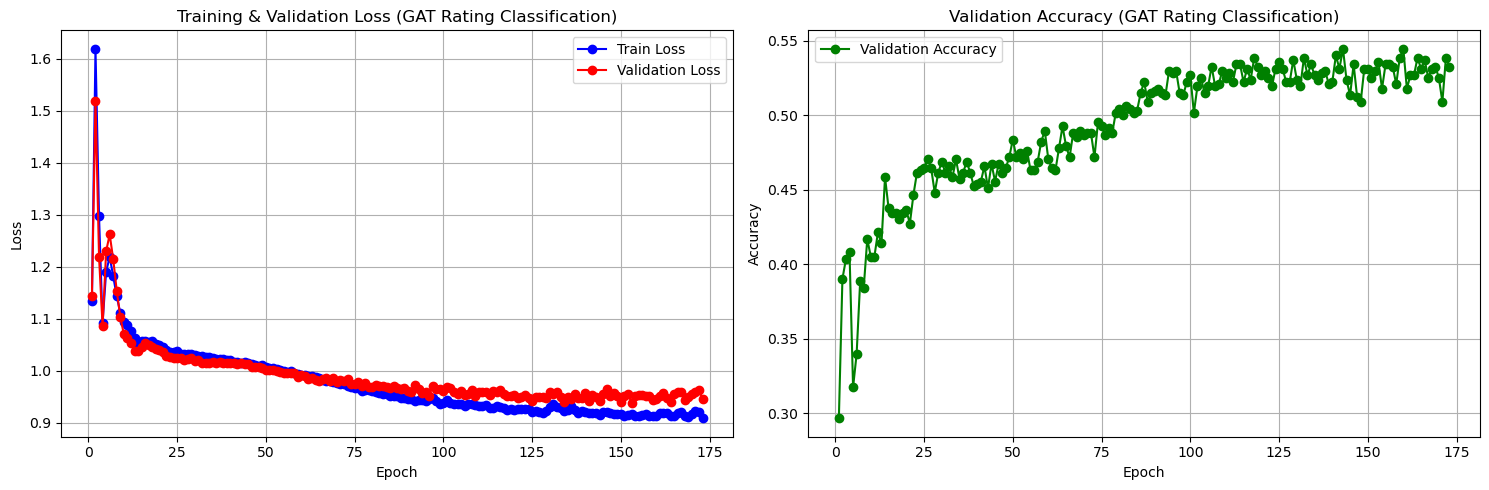

In [ ]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize = (15, 5))

# Subplot 1: Losses
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label = "Train Loss", color = "blue", marker = "o")
plt.plot(epochs, val_losses, label = "Validation Loss", color = "red", marker = "o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss (GAT Rating Classification)")
plt.grid(True)
plt.legend()

# Subplot 2: Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label = "Validation Accuracy", color = "green", marker = "o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy (GAT Rating Classification)")
plt.grid(True)
plt.legend()

plt.tight_layout()
#plt.savefig("../assets/GAT_rating_classification_loss_curves.png", dpi = 300, bbox_inches = "tight")  # Save to file

plt.show()

### Evaluate the Model on the Test Set (GAT)

In [188]:
# Evaluate best model on test set
best_model.eval()
with torch.no_grad():
    out = best_model(data)
    pred = out.argmax(dim = 1)

    y_true = data.y[data.test_mask].cpu().numpy()
    y_pred = pred[data.test_mask].cpu().numpy()

    acc = (y_pred == y_true).mean()
    print(f"Best Config: {best_config}")
    print(f"Test Accuracy: {acc:.4f}")

Best Config: {'hidden_dim': [128], 'lr': 0.01, 'weight_decay': 0.001, 'optimizer': 'Adam', 'dropout_rate': 0.2}
Test Accuracy: 0.5325


### Confusion Matrix (GAT)

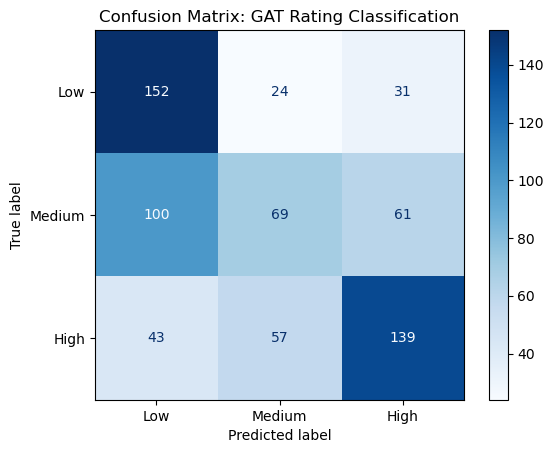

In [ ]:
# Plot all ROC curves
display_labels = [
    "Low",
    "Medium",
    "High"
]

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = display_labels)
disp.plot(cmap = plt.cm.Blues)
plt.title("Confusion Matrix: GAT Rating Classification")
#plt.savefig("../assets/GAT_rating_classification_confusion_matrix.png", dpi = 300, bbox_inches = "tight")  # Save to file

plt.show()


### ROC Curve (GAT)

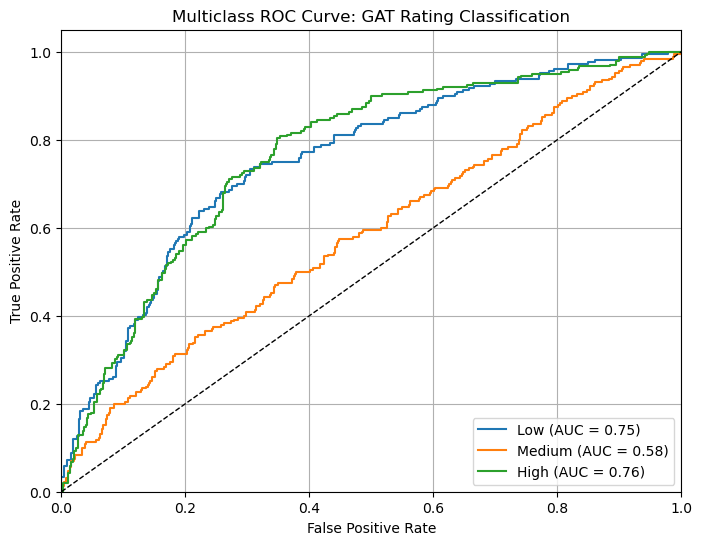

In [ ]:
# Get predicted probabilities
probs = out[data.test_mask].cpu().numpy()

display_labels = np.unique(labels_filtered)

# Binarize true labels for multiclass ROC
y_test_bin = label_binarize(y_true, classes = display_labels)
n_classes = probs.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
display_labels = [
    "Low",
    "Medium",
    "High"
]

plt.figure(figsize = (8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label = f"{display_labels[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw = 1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve: GAT Rating Classification")
plt.legend(loc = "lower right")
plt.grid(True)
#plt.savefig("../assets/GAT_rating_classification_roc_curve.png", dpi = 300, bbox_inches = "tight")
plt.show()

### Track Test Results (GAT)

In [191]:
test_mask = data.test_mask.cpu().numpy()
test_indices = np.where(test_mask)[0]  # indices of test nodes

# Ensure arrays
node_ids_array = np.array(node_ids)
ratings_array = np.array(ratings)

# Get movie names, true labels for test nodes
# Subset for test nodes
movie_ids_test = node_ids_array[valid_rows][test_indices]
true_labels_test = labels_filtered[test_indices]
true_ratings_test = ratings_array[valid_rows][test_indices]

df_test_results = pd.DataFrame({
    "movie_id": movie_ids_test,
    "rating": true_ratings_test,
    "true_label": true_labels_test,
    "pred_label": y_pred
})

df_test_results["correct"] = df_test_results["true_label"] == df_test_results["pred_label"]

accuracy = (df_test_results["true_label"] == df_test_results["pred_label"]).mean()
print(f"Test Accuracy: {accuracy:.3f}")

df_test_results.head(20)


Test Accuracy: 0.533


,movie_id,rating,true_label,pred_label,correct
0,Avengers: Endgame,8.450,2,2,True
1,Furious 7,7.300,2,2,True
2,Rogue One: A Star Wars Story,7.550,2,2,True
3,Pirates of the Caribbean: At World's End,5.925,1,2,False
4,Star Wars: Episode I - The Phantom Menace,5.900,1,2,False
5,Batman v Superman: Dawn of Justice,4.925,0,2,False
6,Wonder Woman,7.850,2,1,False
7,Captain America: The Winter Soldier,7.850,2,2,True
8,Transformers,6.425,1,2,False
9,Fast Five,7.225,2,0,False


## Movie Revenue Classification - GCN and GAT

### Load Dataset and Preprocess

In [5]:
# Load GraphML with NetworkX
G = nx.read_graphml("../data/networks/movie_similarity_network_all_ratings.graphml")

# Extract node features and labels
node_ids = list(G.nodes)
num_nodes = len(node_ids)

# Pick node attributes as features
feature_names = ["budget", "oscar_noms", "oscar_wins", "avg_rating", "runtime", "year"]
features = []
revenues = []

for n in node_ids:
    node_data = G.nodes[n]
    # Extract features and convert to float, handle missing data if needed
    f = []
    for attr in feature_names:
        val = node_data.get(attr)
        if val is None:
            val = 0.0  # or np.nan and handle later
        else:
            val = float(val)
        f.append(val)
    features.append(f)

    # Extract rating for label
    revenue_val = node_data.get("revenue")
    revenue_val = float(revenue_val) if revenue_val is not None else 0.0
    revenues.append(revenue_val)

numeric_features = np.array(features)
revenues = np.array(revenues)

### Encode Text Features

In [6]:
# Extract strings
genre_list = []
age_rating_list = []

for n in node_ids:
    node_data = G.nodes[n]
    
    # Extract Genres
    raw = G.nodes[n].get("genre", "[]")
    try:
        genres = eval(raw)  # convert string to list
    except:
        genres = []
    genre_list.append(genres)

    # Extract Age Rating and split on semicolon
    raw_age_rating = node_data.get("age_rating", "")
    if isinstance(raw_age_rating, str) and raw_age_rating.strip():
        age_rating = raw_age_rating.strip()
    else:
        age_rating = ""
    age_rating_list.append(age_rating)

# Convert to multi-hot encoding
mlb_genre = MultiLabelBinarizer()
mlb_age_rating = MultiLabelBinarizer()

genre_features = mlb_genre.fit_transform(genre_list)
age_rating_features = mlb_age_rating.fit_transform(age_rating_list)

# Calculate centralities
deg_centrality = nx.degree_centrality(G)
close_centrality = nx.closeness_centrality(G)
betw_centrality = nx.betweenness_centrality(G)
eigen_centrality = nx.eigenvector_centrality(G, max_iter = 1000)

# Map to feature list
centrality_features = []
for nid in node_ids:
    centrality_features.append([
        deg_centrality.get(nid, 0.0),
        close_centrality.get(nid, 0.0),
        betw_centrality.get(nid, 0.0),
        eigen_centrality.get(nid, 0.0)
    ])
centrality_features = np.array(centrality_features)

combined_features = np.hstack([numeric_features, genre_features, age_rating_features])

print("Genre shape:", genre_features.shape)
print("Age Rating shape:", age_rating_features.shape)
print("Centrality Shape:", centrality_features.shape)
print("Combined features shape:", combined_features.shape)

Genre shape: (6940, 19)
Age Rating shape: (6940, 9)
Centrality Shape: (6940, 4)
Combined features shape: (6940, 34)


### Bucketize Target Variables

In [7]:
# Bucketize revenue into classes
def bucketize_revenue_quantile(r, revenues, classes):
    quantiles = [np.quantile(revenues, i / classes) for i in range(1, classes)]
    
    for i, q in enumerate(quantiles):
        if r <= q:
            return i
    return classes - 1

classes = 4
labels = np.array([bucketize_revenue_quantile(r, revenues, classes) for r in revenues])

unique, counts = np.unique(labels, return_counts = True)

# Reverse normalization for human-readable interpretation
revenue_mean = 96_570_451.31396617
revenue_std = 184_222_950.90140792
quantiles = [np.quantile(revenues, i / classes) for i in range(1, classes)]
quantiles_original = [(q * revenue_std) + revenue_mean for q in quantiles]

# Print label bucket ranges
for label, count in zip(unique, counts):
    if label == 0:
        print(f"Label {label}: {count} movies - (revenue <= {quantiles_original[0]:,.2f})")
    elif label == classes - 1:
        print(f"Label {label}: {count} movies - (revenue > {quantiles_original[-1]:,.2f})")
    else:
        lower = quantiles_original[label - 1]
        upper = quantiles_original[label]
        print(f"Label {label}: {count} movies - ({lower:,.2f} < revenue <= {upper:,.2f})")

Label 0: 1735 movies - (revenue <= 8,212,310.50)
Label 1: 1735 movies - (8,212,310.50 < revenue <= 38,093,878.00)
Label 2: 1735 movies - (38,093,878.00 < revenue <= 111,906,225.00)
Label 3: 1735 movies - (revenue > 111,906,225.00)


### Remove NaN Nodes and Edges

In [8]:
features = np.array(combined_features)  # shape (num_nodes, num_features)
labels = np.array(labels)      # your bucketized labels
node_ids = np.array(node_ids)  # original node_ids list (do NOT filter yet)

# Find valid nodes (no NaNs in features)
valid_rows = ~np.isnan(features).any(axis=1)

# Filter features and labels by valid_rows
features_filtered = features[valid_rows]
labels_filtered = labels[valid_rows]
node_ids_filtered = np.array(node_ids)[valid_rows]
node_id_to_idx = {nid: idx for idx, nid in enumerate(node_ids_filtered)}

# Build old_to_new mapping for all nodes (original order)
old_to_new = -np.ones(len(node_ids), dtype=int)
old_to_new[np.where(valid_rows)[0]] = np.arange(features_filtered.shape[0])

# Build edge_index and edge_weight using filtered nodes only
filtered_edges_with_weights = []

for src, dst, attr in G.edges(data = True):
    if src in node_id_to_idx and dst in node_id_to_idx:
        new_src = node_id_to_idx[src]
        new_dst = node_id_to_idx[dst]

        weight = float(attr.get("weight", 1.0))
        filtered_edges_with_weights.append((new_src, new_dst, weight))

# Build edge_index and edge_weight tensors
edge_index = torch.tensor([[e[0], e[1]] for e in filtered_edges_with_weights], dtype = torch.long).t().contiguous()
edge_weight = torch.tensor([e[2] for e in filtered_edges_with_weights], dtype = torch.float)

num_nodes_filtered = features_filtered.shape[0]
print("Number of nodes before filtering:", len(node_ids))
print("Number of nodes before filtering:", num_nodes_filtered)

Number of nodes before filtering: 6940
Number of nodes before filtering: 6746


### Standardize Features and Convert to Torch Tensors

In [9]:
scaler = StandardScaler()
features_filtered = scaler.fit_transform(features_filtered)

# Convert to torch tensors
x = torch.tensor(features_filtered, dtype = torch.float)
y = torch.tensor(labels_filtered, dtype = torch.long)

### Split Dataset into Training, Validation, and Testing Sets

In [10]:
# Create train/test masks
num_nodes = num_nodes_filtered
num_train = int(0.8 * num_nodes)
num_val = int(0.1 * num_nodes)
num_test = num_nodes - num_train - num_val

perm = torch.randperm(num_nodes)
train_idx = perm[:num_train]
val_idx = perm[num_train : num_train + num_val]
test_idx = perm[num_train + num_val:]

train_mask = torch.zeros(num_nodes, dtype = torch.bool)
val_mask = torch.zeros(num_nodes, dtype = torch.bool)
test_mask = torch.zeros(num_nodes, dtype = torch.bool)

train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

# Create data object
data = Data(x = x,
            edge_index = edge_index,
            edge_weight = edge_weight,
            y = y,
            train_mask = train_mask,
            val_mask = val_mask,
            test_mask = test_mask)

nan_mask = np.isnan(features_filtered)
print("NaNs per column:", np.sum(nan_mask, axis = 0))


NaNs per column: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Tune Hyperparameters (GCN)

In [11]:
param_grid = {
    "hidden_dim": [[32], [32, 32], [64], [64, 64], [128], [128, 128]],
    "lr": [0.01, 0.001],
    "weight_decay": [1e-3],
    "optimizer": ["Adam", "SGD", "RMSProp"],
    "dropout_rate": [0.1, 0.2]
}

# Tune Hyperparameters with the custom configurations
best_model, best_config, best_loss = hyperparameter_tuning(
    data = data,
    input_dim = x.shape[1],
    output_dim = len(np.unique(labels)),
    param_grid = param_grid,
    epochs = 200,
    model_type = "GCN"
)

# Sanity check for input and output dimensions
print(f"Input Dimension: {x.shape[1]}")
print(f"Output Dimension: {len(np.unique(labels))}\n")

# Print best model configuration
print(f"Best Config: {best_config}")
print(f"Best Validation Loss: {best_loss:.4f}")


Model 1/12: hidden_dim = [32] | lr = 0.01 | weight_decay = 0.001 | optimizer = Adam | dropout_rate = 0.1
Early stopping triggered at epoch 186
Best Validation Loss: 0.9466

Model 2/12: hidden_dim = [32] | lr = 0.001 | weight_decay = 0.001 | optimizer = Adam | dropout_rate = 0.1
Best Validation Loss: 1.0667

Model 3/12: hidden_dim = [32, 32] | lr = 0.01 | weight_decay = 0.001 | optimizer = Adam | dropout_rate = 0.1
Early stopping triggered at epoch 147
Best Validation Loss: 1.0010

Model 4/12: hidden_dim = [32, 32] | lr = 0.001 | weight_decay = 0.001 | optimizer = Adam | dropout_rate = 0.1
Early stopping triggered at epoch 158
Best Validation Loss: 1.0877

Model 5/12: hidden_dim = [64] | lr = 0.01 | weight_decay = 0.001 | optimizer = Adam | dropout_rate = 0.1
Early stopping triggered at epoch 155
Best Validation Loss: 0.9390

Model 6/12: hidden_dim = [64] | lr = 0.001 | weight_decay = 0.001 | optimizer = Adam | dropout_rate = 0.1
Best Validation Loss: 1.0146

Model 7/12: hidden_dim = [3

### Train the Best Model (GCN)

In [54]:
# Retrain with best hyperparameters
best_model, best_val_loss, train_losses, val_accuracies, val_losses = train_model(
    data = data,
    input_dim = data.num_node_features,
    output_dim = len(np.unique(labels)),
    hidden_dim = best_config["hidden_dim"],
    lr = best_config["lr"],
    weight_decay = best_config["weight_decay"],
    optimizer_type = best_config["optimizer"],
    dropout_rate = best_config["dropout_rate"],
    epochs = 200,
    model_type = "GCN"
)

print(f"Best Model: {best_model}")
print(f"Best Validation Loss: {best_val_loss:.4f}")

'''
-----PREVIOUS BEST-----
Best Config: {'hidden_dim': [128], 'lr': 0.01, 'weight_decay': 0.001, 'optimizer': 'Adam', 'dropout_rate': 0.1}
Best Validation Loss: 0.8937
Test Accuracy: 0.6361
'''

Early stopping triggered at epoch 147
Best Model: GCN_Classification(
  (convs): ModuleList(
    (0): GCNConv(34, 64)
  )
  (out): GCNConv(64, 4)
)
Best Validation Loss: 0.9265


"\n-----PREVIOUS BEST-----\nBest Config: {'hidden_dim': [128], 'lr': 0.01, 'weight_decay': 0.001, 'optimizer': 'Adam', 'dropout_rate': 0.1}\nBest Validation Loss: 0.8937\nTest Accuracy: 0.6361\n"

### Visualize Training and Validation Results  (GCN)

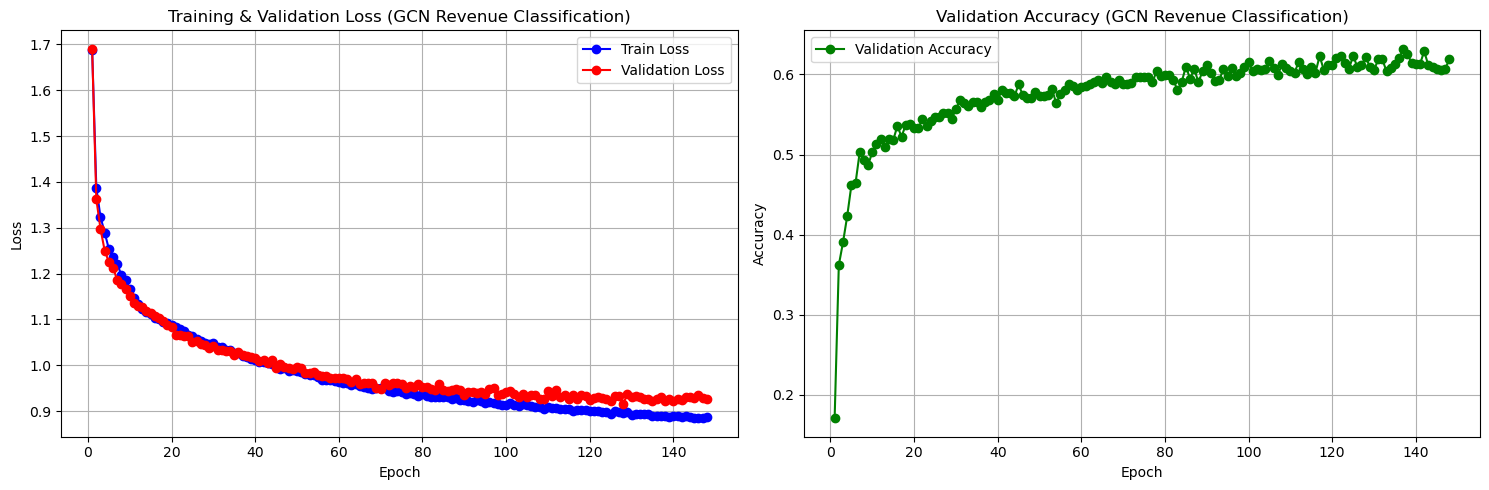

In [55]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize = (15, 5))

# Subplot 1: Losses
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label = "Train Loss", color = "blue", marker = "o")
plt.plot(epochs, val_losses, label = "Validation Loss", color = "red", marker = "o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss (GCN Revenue Classification)")
plt.grid(True)
plt.legend()

# Subplot 2: Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label = "Validation Accuracy", color = "green", marker = "o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy (GCN Revenue Classification)")
plt.grid(True)
plt.legend()

plt.tight_layout()
#plt.savefig("../assets/GCN_revenue_classification_loss_curves.png", dpi = 300, bbox_inches = "tight")

plt.show()

### Evaluate the Model on the Test Set (GCN)

In [56]:
# Evaluate best model on test set
best_model.eval()
with torch.no_grad():
    out = best_model(data)  # [num_nodes, num_classes]
    pred = out.argmax(dim = 1)

    y_true = data.y[data.test_mask].cpu().numpy()
    y_pred = pred[data.test_mask].cpu().numpy()

    acc = (y_pred == y_true).mean()
    print(f"Best Config: {best_config}")
    print(f"Test Accuracy: {acc:.4f}")

Best Config: {'hidden_dim': [64], 'lr': 0.01, 'weight_decay': 0.001, 'optimizer': 'Adam', 'dropout_rate': 0.1}
Test Accuracy: 0.6228


### Confusion Matrix (GCN)

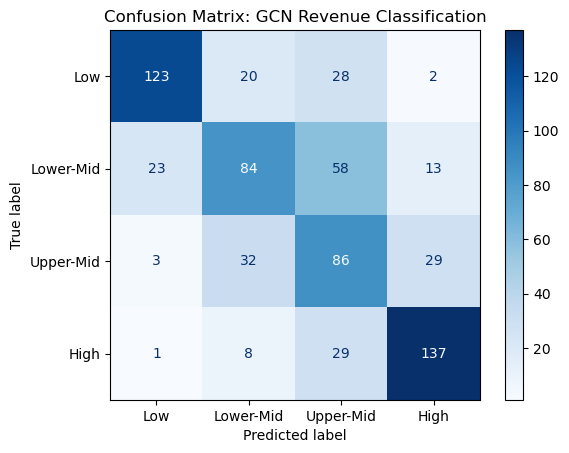

In [ ]:
display_labels = [
    "Low",
    "Lower-Mid",
    "Upper-Mid",
    "High"
]

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = display_labels)
disp.plot(cmap = plt.cm.Blues)
plt.title("Confusion Matrix: GCN Revenue Classification")
#plt.savefig("../assets/GCN_revenue_classification_confusion_matrix.png", dpi = 300, bbox_inches = "tight")  # Save to file

plt.show()


### ROC Curve (GCN)

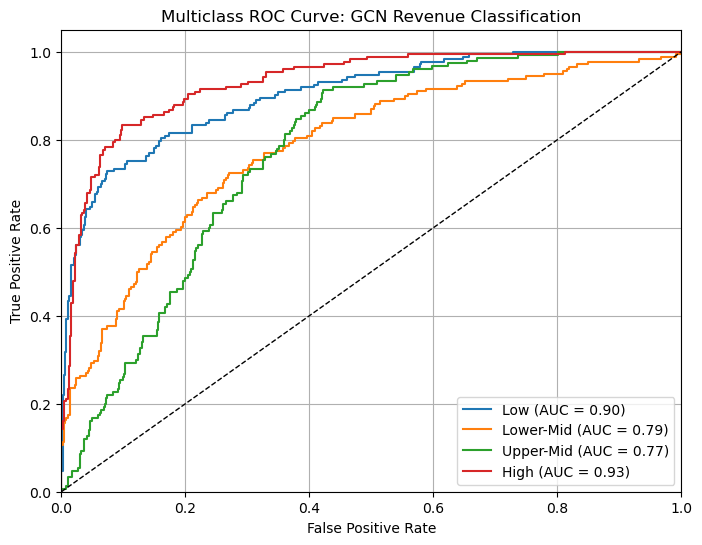

In [ ]:
# Get predicted probabilities
probs = out[data.test_mask].cpu().numpy()

display_labels = np.unique(labels_filtered)

# Binarize true labels for multiclass ROC
y_test_bin = label_binarize(y_true, classes = display_labels)
n_classes = probs.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
display_labels = [
    "Low",
    "Lower-Mid",
    "Upper-Mid",
    "High"
]

plt.figure(figsize = (8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label = f"{display_labels[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw = 1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve: GCN Revenue Classification")
plt.legend(loc = "lower right")
plt.grid(True)
#plt.savefig("../assets/GCN_revenue_classification_roc_curve.png", dpi = 300, bbox_inches = "tight")
plt.show()

### Track Test Results (GCN)

In [44]:
test_mask = data.test_mask.cpu().numpy()
test_indices = np.where(test_mask)[0]  # indices of test nodes

# Get movie names, true labels for test nodes
movie_ids_test = node_ids[valid_rows][test_indices]
true_labels_test = labels_filtered[test_indices]

true_revenue_test = revenues[valid_rows][test_indices]

revenue_mean = 96570451.31396617
revenue_std = 184222950.9014079

revenue_scalar_true = []
for i in true_revenue_test:
    value = (i * revenue_std) + revenue_mean
    revenue_scalar_true.append(value)

df_test_results = pd.DataFrame({
    "movie_id": movie_ids_test,
    "revenue_normalized": true_revenue_test,
    "revenue": revenue_scalar_true,
    "true_label": true_labels_test,
    "pred_label": y_pred
})

df_test_results["correct"] = df_test_results["true_label"] == df_test_results["pred_label"]

accuracy = (df_test_results["true_label"] == df_test_results["pred_label"]).mean()
print(f"Test Accuracy: {accuracy:.3f}")

df_test_results.head(20)


Test Accuracy: 0.636


,movie_id,revenue_normalized,revenue,true_label,pred_label,correct
0,The Avengers (2012),7.720238,1.518816e+09,3,3,True
1,Avengers: Age of Ultron,7.104616,1.405404e+09,3,3,True
2,Incredibles 2,6.221998,1.242805e+09,3,3,True
3,Jumanji: Welcome to the Jungle,4.878701,9.953391e+08,3,3,True
4,Pirates of the Caribbean: At World's End,4.696053,9.616912e+08,3,3,True
5,Star Wars: Episode III - Revenge of the Sith,4.089770,8.500000e+08,3,3,True
6,Independence Day,3.912816,8.174009e+08,3,3,True
7,Fast X,3.301104,7.047097e+08,3,3,True
8,Mission: Impossible - Ghost Protocol,3.246843,6.947134e+08,3,3,True
9,Big Hero 6,3.046852,6.578705e+08,3,3,True


### Tune Hyperparameters (GAT)

In [57]:
param_grid = {
    "hidden_dim": [[64]],
    "lr": [0.01],
    "weight_decay": [1e-3],
    "optimizer": ["Adam"],
    "dropout_rate": [0.1]
}

# Tune Hyperparameters with the custom configurations
best_model, best_config, best_loss = hyperparameter_tuning(
    data = data,
    input_dim = x.shape[1],
    output_dim = len(np.unique(labels)),
    param_grid = param_grid,
    epochs = 200,
    model_type = "GAT"
)

# Sanity check for input and output dimensions
print(f"Input Dimension: {x.shape[1]}")
print(f"Output Dimension: {len(np.unique(labels))}\n")

# Print best model configuration
print(f"Best Config: {best_config}")
print(f"Best Validation Loss: {best_loss:.4f}")


Model 1/1: hidden_dim = [64] | lr = 0.01 | weight_decay = 0.001 | optimizer = Adam | dropout_rate = 0.1
Early stopping triggered at epoch 161
Best Validation Loss: 0.7590

Input Dimension: 34
Output Dimension: 4

Best Config: {'hidden_dim': [64], 'lr': 0.01, 'weight_decay': 0.001, 'optimizer': 'Adam', 'dropout_rate': 0.1}
Best Validation Loss: 0.7590


### Train the Best Model (GAT)

In [64]:
# Retrain with best hyperparameters
best_model, best_val_loss, train_losses, val_accuracies, val_losses = train_model(
    data = data,
    input_dim = data.num_node_features,
    output_dim = len(np.unique(labels)),
    hidden_dim = best_config["hidden_dim"],
    lr = best_config["lr"],
    weight_decay = best_config["weight_decay"],
    optimizer_type = best_config["optimizer"],
    dropout_rate = best_config["dropout_rate"],
    epochs = 150,
    model_type = "GAT"
)

print(f"Best Model: {best_model}")
print(f"Best Validation Loss: {best_val_loss:.4f}")

'''
-----PREVIOUS BEST-----
Best Config: {'hidden_dim': [64], 'lr': 0.01, 'weight_decay': 0.001, 'optimizer': 'Adam', 'dropout_rate': 0.1}
Best Validation Loss: 0.7249
Test Accuracy: 0.7041
'''

Best Model: GAT_Classification(
  (convs): ModuleList(
    (0): GATConv(34, 64, heads=2)
  )
  (out): GATConv(128, 4, heads=1)
)
Best Validation Loss: 0.7482


"\n-----PREVIOUS BEST-----\nBest Config: {'hidden_dim': [64], 'lr': 0.01, 'weight_decay': 0.001, 'optimizer': 'Adam', 'dropout_rate': 0.1}\nBest Validation Loss: 0.7249\nTest Accuracy: 0.7041\n"

### Visualize Training and Validation Results  (GAT)

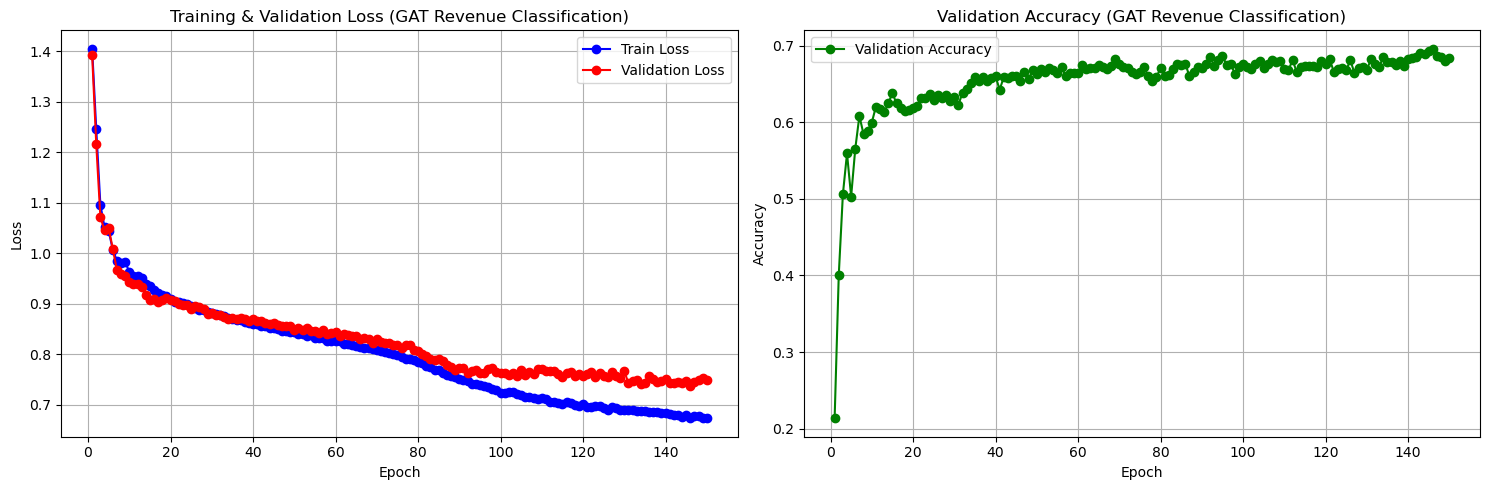

In [65]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize = (15, 5))

# Subplot 1: Losses
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label = "Train Loss", color = "blue", marker = "o")
plt.plot(epochs, val_losses, label = "Validation Loss", color = "red", marker = "o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss (GAT Revenue Classification)")
plt.grid(True)
plt.legend()

# Subplot 2: Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label = "Validation Accuracy", color = "green", marker = "o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy (GAT Revenue Classification)")
plt.grid(True)
plt.legend()

plt.tight_layout()
#plt.savefig("../assets/GAT_revenue_classification_loss_curves.png", dpi = 300, bbox_inches = "tight")  # Save to file

plt.show()

### Evaluate the Model on the Test Set (GAT)

In [66]:
# Evaluate best model on test set
best_model.eval()
with torch.no_grad():
    out = best_model(data)  # [num_nodes, num_classes]
    pred = out.argmax(dim = 1)

    y_true = data.y[data.test_mask].cpu().numpy()
    y_pred = pred[data.test_mask].cpu().numpy()

    acc = (y_pred == y_true).mean()
    print(f"Best Config: {best_config}")
    print(f"Test Accuracy: {acc:.4f}")

Best Config: {'hidden_dim': [64], 'lr': 0.01, 'weight_decay': 0.001, 'optimizer': 'Adam', 'dropout_rate': 0.1}
Test Accuracy: 0.6953


### Confusion Matrix (GAT)

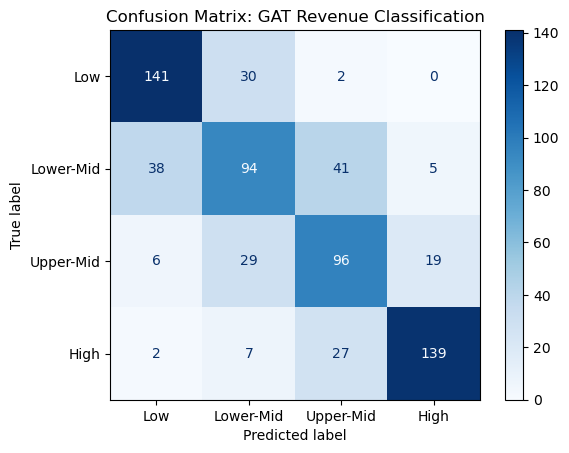

In [67]:
display_labels = [
    "Low",
    "Lower-Mid",
    "Upper-Mid",
    "High"
]

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = display_labels)
disp.plot(cmap = plt.cm.Blues)
plt.title("Confusion Matrix: GAT Revenue Classification")
#plt.savefig("../assets/GAT_revenue_classification_confusion_matrix.png", dpi = 300, bbox_inches = "tight")  # Save to file

plt.show()


### ROC Curve (GAT)

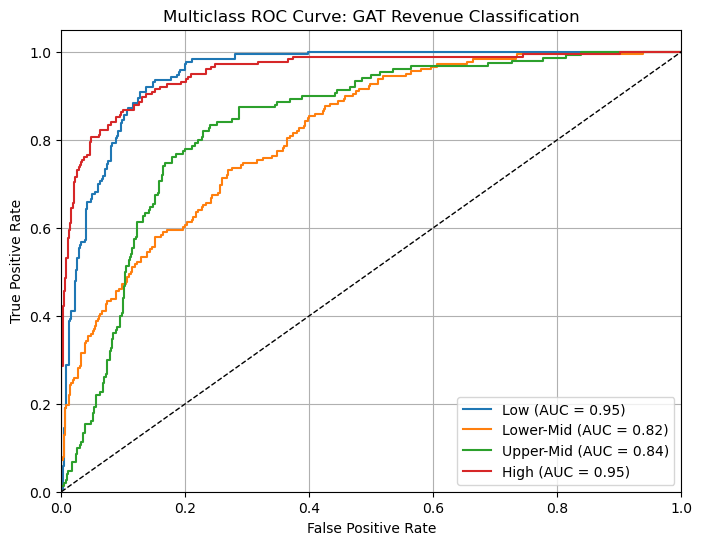

In [68]:
# Get predicted probabilities
probs = out[data.test_mask].cpu().numpy()

display_labels = np.unique(labels_filtered)

# Binarize true labels for multiclass ROC
y_test_bin = label_binarize(y_true, classes = display_labels)
n_classes = probs.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
display_labels = [
    "Low",
    "Lower-Mid",
    "Upper-Mid",
    "High"
]

plt.figure(figsize = (8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label = f"{display_labels[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw = 1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve: GAT Revenue Classification")
plt.legend(loc = "lower right")
plt.grid(True)
#plt.savefig("../assets/GAT_revenue_classification_roc_curve.png", dpi = 300, bbox_inches = "tight")
plt.show()

### Track Test Results (GAT)

In [24]:
test_mask = data.test_mask.cpu().numpy()
test_indices = np.where(test_mask)[0]  # indices of test nodes

# Get movie names, true labels for test nodes
movie_ids_test = node_ids[valid_rows][test_indices]
true_labels_test = labels_filtered[test_indices]

true_revenue_test = revenues[valid_rows][test_indices]

revenue_mean = 96570451.31396617
revenue_std = 184222950.9014079

revenue_scalar_true = []
for i in true_revenue_test:
    value = (i * revenue_std) + revenue_mean
    revenue_scalar_true.append(value)

df_test_results = pd.DataFrame({
    "movie_id": movie_ids_test,
    "revenue_normalized": true_revenue_test,
    "revenue": revenue_scalar_true,
    "true_label": true_labels_test,
    "pred_label": y_pred
})

df_test_results["correct"] = df_test_results["true_label"] == df_test_results["pred_label"]

accuracy = (df_test_results["true_label"] == df_test_results["pred_label"]).mean()
print(f"Test Accuracy: {accuracy:.3f}")

df_test_results.head(20)


Test Accuracy: 0.689


,movie_id,revenue_normalized,revenue,true_label,pred_label,correct
0,The Avengers (2012),7.720238,1.518816e+09,3,3,True
1,Avengers: Age of Ultron,7.104616,1.405404e+09,3,3,True
2,Incredibles 2,6.221998,1.242805e+09,3,3,True
3,Jumanji: Welcome to the Jungle,4.878701,9.953391e+08,3,3,True
4,Pirates of the Caribbean: At World's End,4.696053,9.616912e+08,3,3,True
5,Star Wars: Episode III - Revenge of the Sith,4.089770,8.500000e+08,3,3,True
6,Independence Day,3.912816,8.174009e+08,3,3,True
7,Fast X,3.301104,7.047097e+08,3,3,True
8,Mission: Impossible - Ghost Protocol,3.246843,6.947134e+08,3,3,True
9,Big Hero 6,3.046852,6.578705e+08,3,3,True
